<a href="https://colab.research.google.com/github/prithvi-poddar/my_linear_regressors_assignment/blob/master/Prithvi_Poddar_17191_report_2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Report 2**

## **Prithvi Poddar 17191**


### In this report, we'll implement a simple Convolutional Neural Network and train it on the entire MNIST dataset so see the results.

#### P.S. This notebook was created entirely in google colab as it provides GPU facility, so that the training can be faster. Thus, I had to mention all the classes wwithin the notebook itself as I cannot import classes from my local machine.

We will be using PyTorch for this notebook

Run the next line if your computer doen't have pytorch installed. Otherwise you can skip it.

In [ ]:
!pip3 install torch torchvision

In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

Creating the transform function to convert the images into tensors that are readable by pytorch

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5))])

Downloading the MNIST dataset from torchvision

In [5]:
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [6]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Now we define the training function. We'll be using the Cross Entropy loss and the Adam optimizer.

In [7]:
def train(model, epochs, learning_rate):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  training_losses=[]
  training_accuracies=[]
  test_losses=[]
  test_accuracies=[]

  for e in range(epochs):
    training_loss = 0.0
    training_accuracy = 0.0
    test_loss = 0.0
    test_accuracy = 0.0

    for inputs, labels in training_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _, preds = torch.max(outputs, 1) #returns the max value along axis 1 along with its index
      training_loss += loss.item()
      training_accuracy += torch.sum(preds==labels.data)

    else:
      with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model.forward(val_inputs)
          val_loss = criterion(val_outputs, val_labels)

          _, val_preds = torch.max(val_outputs, 1)
          test_loss += val_loss.item()
          test_accuracy += torch.sum(val_preds == val_labels.data)

      epoch_loss = training_loss/len(training_loader)
      epoch_acc = training_accuracy.float()/ len(training_loader)
      training_losses.append(epoch_loss)
      training_accuracies.append(epoch_acc)

      val_epoch_loss = test_loss/len(validation_loader)
      val_epoch_acc = test_accuracy.float()/ len(validation_loader)
      test_losses.append(val_epoch_loss)
      test_accuracies.append(val_epoch_acc)
      print('epoch :', (e+1))
      print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
      print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    
  return training_losses, training_accuracies, test_losses ,test_accuracies

Defining the plotting function to plot the accuracies and losses later on

In [8]:
def plot_loss(training_losses, testing_losses):
  plt.plot(training_losses, label='training loss')
  plt.plot(testing_losses, label='testing loss')
  plt.legend()

In [9]:
def plot_accuracy(training_accuracies, testing_accuracies):
  plt.plot(training_accuracies, label='training accuracy')
  plt.plot(testing_accuracies, label='testing accuracy')
  plt.legend()

### Having defined the helping functions, we can now start forming our CNN module.
#### Since, training takes substantial time, even when using a gpu, I'll be referring to the results from https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist 
#### In the above mentioned link, experiments have already been done to determine the optimum parameters for training on the MNIST data set

For our model ,we'll have **2 convolutional layers**. The **first one with 32 filetrs and second one with 64 filters**. **Filter size will be 5 with stride=1** There will be **2 fully connected layers with 128 neurons in the first layer and 10 in the second layer** which will be the output layer. Activation function will be **RELU with softmax applied to the last layer**. Intermediate **max pooling will be done with kernel size=2 and strides=2. Dropout in the fully connected layer will be 0.4**

Important formulae that we'll need are:

**Output height = ((height-kernel_size+2*padding)/stride)+1**

**Output width = ((width-kernel_size+2*padding)/stride)+1**

**We'll use max_pooling of size 2 and stride 2. This will simply half the size of the feature map, hence making our manual calculations easier**

In [10]:
class Network_CNN(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 32, 5, 1)
      self.conv2 = nn.Conv2d(32, 64, 5, 1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.4)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = F.softmax(self.fc2(x), dim=1)
      return x

    def visualize(self, x):
      a = F.relu(self.conv1(x))
      b = F.max_pool2d(a, 2, 2)
      c = F.relu(self.conv2(b))
      d = F.max_pool2d(c, 2, 2)
      return a, b, c, d

In [11]:
model = Network_CNN().to(device)
model

Network_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [12]:
training_losses, training_accuracies, test_losses, test_accuracies = train(model, 50, 0.0001)

epoch : 1
training loss: 1.6740, acc 82.4383 
validation loss: 1.5233, validation acc 94.5700 
epoch : 2
training loss: 1.5132, acc 95.5450 
validation loss: 1.4992, validation acc 96.7700 
epoch : 3
training loss: 1.4975, acc 96.8550 
validation loss: 1.4892, validation acc 97.6100 
epoch : 4
training loss: 1.4887, acc 97.5900 
validation loss: 1.4865, validation acc 97.7100 
epoch : 5
training loss: 1.4851, acc 97.8933 
validation loss: 1.4812, validation acc 98.3000 
epoch : 6
training loss: 1.4818, acc 98.1717 
validation loss: 1.4789, validation acc 98.4100 
epoch : 7
training loss: 1.4793, acc 98.3817 
validation loss: 1.4776, validation acc 98.5000 
epoch : 8
training loss: 1.4776, acc 98.5467 
validation loss: 1.4775, validation acc 98.4700 
epoch : 9
training loss: 1.4760, acc 98.6900 
validation loss: 1.4750, validation acc 98.8600 
epoch : 10
training loss: 1.4743, acc 98.8600 
validation loss: 1.4747, validation acc 98.7600 
epoch : 11
training loss: 1.4739, acc 98.8900 
va

#### We get an accuracy of 99%, much more than what we achieved earlier using just fully connected linear neural networks

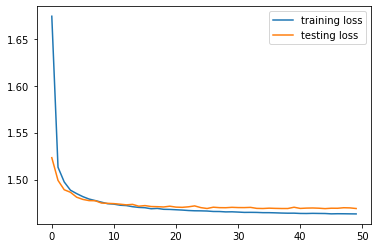

In [13]:
plot_loss(training_losses, test_losses)

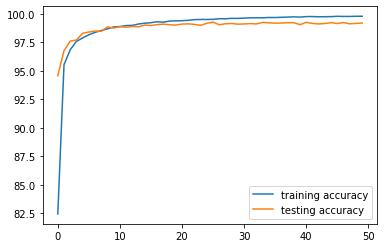

In [14]:
plot_accuracy(training_accuracies, test_accuracies)

I had already done some pre-testing with the learning rate and it turned out that a slow learning rate provides a smoother accuracy curve as this network is quite complex in terms of the parameters to be learned

### Now lets take a look at the indivisual concolutional layer outputs to try to visualize what the model is learning

In [15]:
data = iter(training_loader)
images, labels = data.next()

In [16]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [31]:
def filter_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.clip(0, 1)
  return image

Text(0.5, 1.0, '5')

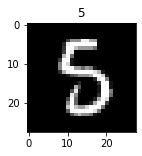

In [23]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(im_convert(images[3]))
plt.title(str(labels[3].item()))

So this will be the input to our network i.e. the image of '5'

In [19]:
a, b, c, d = model.visualize(images.to(device))

### Looking at the output of Conv. Layer 1

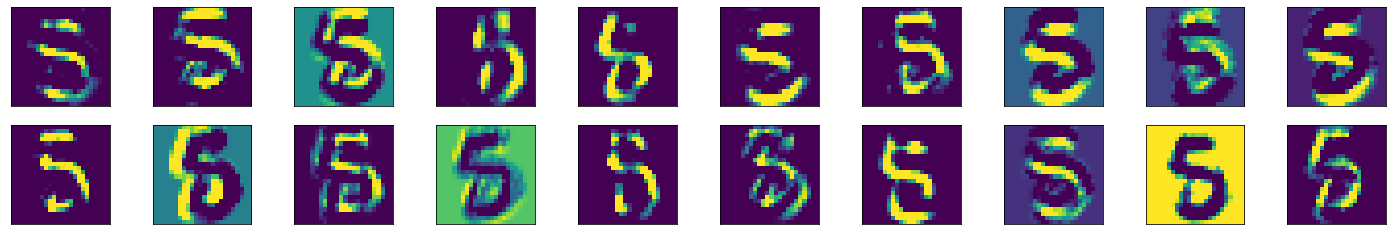

In [32]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(filter_convert(a[3][idx]))

### Output of the max pool of Conv Layer 1

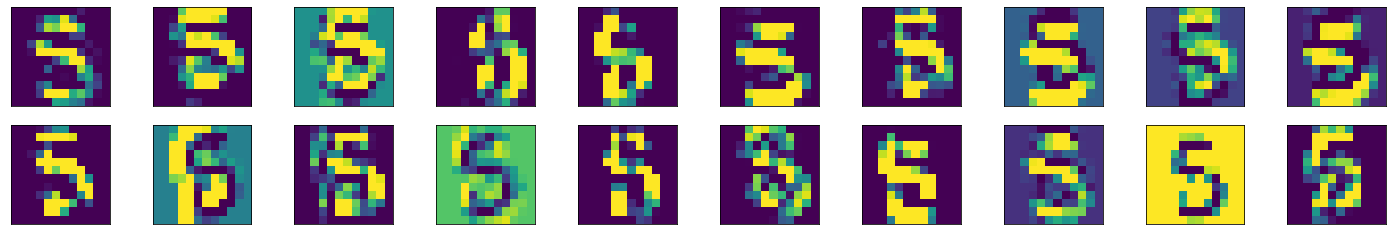

In [26]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(filter_convert(b[3][idx]))

### Output of Conv Layer 2

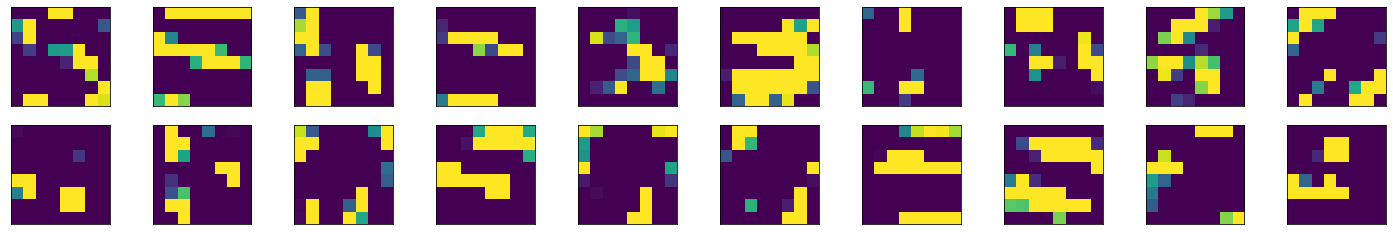

In [27]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(filter_convert(c[3][idx]))

### Output of max pool of Conv Layer 2

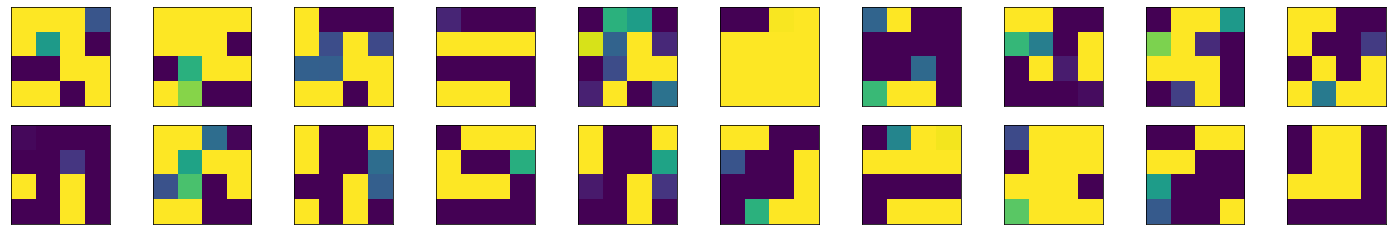

In [28]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(filter_convert(d[3][idx]))

## Analysis of the above filter images

### We can see that the 1st Conv Layer grabs the entire image of 5 as a whole along with the major curves and dashes

### The second Conv Layer grabs the smaller curves and bends that are specific to only the number 5

### At the end, the number 5 is just a superposition of these curves and dashes and hence the network is able to recognize it!!